<a href="https://colab.research.google.com/github/hyunbini/Project/blob/main/IDSL_LAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Library

In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from numpy import dot
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

Mounted at /content/drive


Function used in code

In [ ]:
def check_nan(file):
  result = file.isnull().sum()
  return result

In [ ]:
#Function that extracts user_id who wrote one or more reviews
#input : series(pandas dataframe)
#output : result(list)
def make_list(series1):
  result = []
  for i in range(series1.size):
    #Add user_id who have written reviews more than once to the new list
    if series1[i]>1:
      result.append(series1.index[i])
  return result

In [ ]:
#Function that erases unnecessary characters and makes a list of only the necessary data
#input : list1(list)
#output : result_listset(list)
def remove_special(list1):
  #Change list to string
  for i in range(len(list1)):
    list1[i] = str(list1[i])
  listset_str = ' '.join(list1)
  #Remove Special characters to space
  listset_str = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', "",listset_str)
  #Split the data by space
  result_listset = listset_str.split(' ')
  return result_listset

In [ ]:
#Function that labels data composed of complex characters numerically based on ascending order\
#input : list1(list to be replaced), list2(reference list), dic(dictionary to store the values of reference list and its unique labeling numbers)
#output : list_df(Dataframe made from a labeled list)
def labeling(list1,list2,dic):
  i = 0
  for data in list1:
    if data in list2:
      if data in dic.keys():
        list1[i] = dic[data]
      else:
        dic[data] = i
        list1[i] = i
      i = i+1
    else:
      list1[i] = i
      i = i+1
  for y in range(len(list1)):
    list1[y] = list1[y]+1
  list_df = pd.DataFrame(data=list1, columns= ['label_id'])
  return list_df

Import Data and Remove NaN Value and Unuseful Columns



In [29]:
meta_json = pd.read_json('/content/drive/MyDrive/IDSL Recruitment/[Data 1] Eng - Review Analysis/metadata.json')
review_json = pd.read_json('/content/drive/MyDrive/IDSL Recruitment/[Data 1] Eng - Review Analysis/reviews.json')
print(meta_json.head())
print(review_json.head())
print(check_nan(meta_json))
print(check_nan(review_json))

  main_category                                              title  \
0    All Beauty  Howard LC0008 Leather Conditioner, 8-Ounce (4-...   
1    All Beauty  Lurrose 100Pcs Full Cover Fake Toenails Artifi...   
2    All Beauty                         Gold extatic Musk EDT 90ml   
3    All Beauty  Brand New Headrang Face line Contour V-line Ma...   
4    All Beauty  7 Packs Deep Wave Crochet Hair 22 Inch Deep wa...   

   average_rating  rating_number  \
0             4.8             10   
1             3.7             35   
2             3.7              2   
3             3.3              4   
4             3.4             10   

                                            features  \
0                                                 []   
1  [The false toenails are durable with perfect l...   
2  [Extatic Balmain Gold Musk By Balmain Edt Spra...   
3                                                 []   
4                                                 []   

                         

In [56]:
metadata = meta_json.drop(['rating_number','categories','videos', 'bought_together', 'subtitle', 'author'],axis = 1)
print(metadata.head())
review = review_json.drop(['title', 'text','images','timestamp','user_id','helpful_vote','verified_purchase'],axis=1)
print(review.head())

  main_category                                              title  \
0    All Beauty  Howard LC0008 Leather Conditioner, 8-Ounce (4-...   
1    All Beauty  Lurrose 100Pcs Full Cover Fake Toenails Artifi...   
2    All Beauty                         Gold extatic Musk EDT 90ml   
3    All Beauty  Brand New Headrang Face line Contour V-line Ma...   
4    All Beauty  7 Packs Deep Wave Crochet Hair 22 Inch Deep wa...   

   average_rating                                           features  \
0             4.8                                                 []   
1             3.7  [The false toenails are durable with perfect l...   
2             3.7  [Extatic Balmain Gold Musk By Balmain Edt Spra...   
3             3.3                                                 []   
4             3.4                                                 []   

                                         description  price  \
0                                                 []   None   
1  [Description, The

Extracting duplicate data and labeling of the user_id value to be used for prediction

In [ ]:
id = review_json['user_id']
print("The total number of reviews is", id.size)
id_count = (id.value_counts())
print("The user who wrote the review is", id_count.size)
dup_ind = make_list(id_count)

The total number of reviews is 70883
The user who wrote the review is 68934


<ipython-input-4-17c3463facae>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if series1[i]>1:


In [ ]:
new_user_id = id.to_list()
result_dup_id = remove_special(dup_ind)
result_user_id = remove_special(new_user_id)
label_dic = {}
label_df = labeling(result_user_id,result_dup_id,label_dic)

Data Visualization

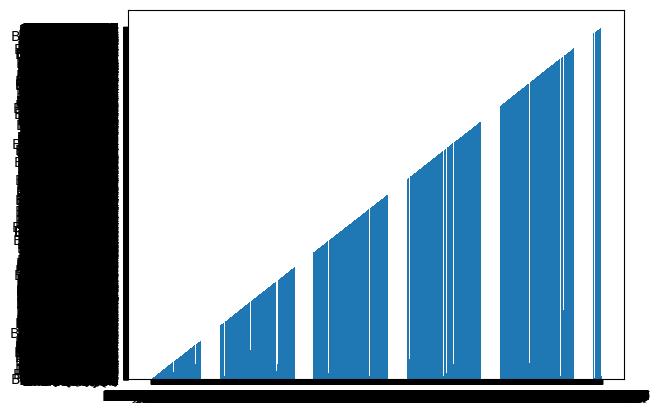

In [ ]:
asin = review['asin']
asin_parent = review['parent_asin']
#plt.plot(asin,asin_parent, 'b+')
plt.bar(asin, asin_parent)
plt.show()

Text Processing & Cosine SImilarity

In [44]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
def text_preprocessing(column):
    #make all words with lower letters
    column = column.str.lower()
    #getting rid of any punctution
    column = column.str.replace('http\S+|www.\S+|@|"\"\:|,|[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'{\}\…》\”\“\’·]', '', case=False)
    #spliting each sentence to words to apply previous funtions on them
    word_tokens = column.str.split()
    keywords = word_tokens.apply(lambda x: [item for item in x if item not in stop])
    #assemble words of each sentence again and assign them in new column
    for i in range(len(keywords)):
        keywords[i] = " ".join(keywords[i])
        column = keywords

    return column

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
df = metadata['details']
df = df.astype(str)
print(df.info())
new_df = text_preprocessing(df)
print(new_df)

<class 'pandas.core.series.Series'>
RangeIndex: 11257 entries, 0 to 11256
Series name: details
Non-Null Count  Dtype 
--------------  ----- 
11257 non-null  object
dtypes: object(1)
memory usage: 88.1+ KB
None
0        {"package dimensions": "7.1 x 5.5 x 3 inches; ...
1        {"color": "as shown", "size": "large", "materi...
2        {"brand": "balmain", "item form": "spray", "it...
3        {"is discontinued manufacturer": "no", "packag...
4        {"brand": "yun mei hair", "material": "synthet...
                               ...                        
11252    {"product dimensions": "7 x 3 x 2 inches; 1.43...
11253                                                   {}
11254    {"brand": "creamily", "material": "human hair"...
11255    {"color": "black", "brand": "olibolla", "item ...
11256                                                   {}
Name: details, Length: 11257, dtype: object


In [67]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

CV = CountVectorizer()
converted_metrix = CV.fit_transform(new_df)
new_metrix = CV.fit_transform(new_df)

cosine_similarity = cosine_similarity(new_metrix)
print(cosine_similarity)

[[1.         0.21821789 0.11145564 ... 0.29649973 0.30237158 0.        ]
 [0.21821789 1.         0.22700174 ... 0.26419797 0.23094011 0.        ]
 [0.11145564 0.22700174 1.         ... 0.28915747 0.23590713 0.        ]
 ...
 [0.29649973 0.26419797 0.28915747 ... 1.         0.27456259 0.        ]
 [0.30237158 0.23094011 0.23590713 ... 0.27456259 1.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


Modeling

In [79]:
def labeling(list1):
  i = 0
  for data in list1:
      list1[i] = i
      i = i+1
  return list1

metadata['parent_asin'] = labeling(metadata['parent_asin'])

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
<ipython-input-79-2e3d3cd62364>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list1[i] = i
<ipython-input-79-2e3d3cd62364>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list1[i] = i
<ipython-input-79-2e3d3cd62364>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list1[i] = i
<ipython-input-79-2e3d3cd62364>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [94]:

import cv2
import numpy as np
import requests

In [130]:
exdata = metadata[metadata['details'].str.contains('Spray')]
product_id = exdata['parent_asin'].values[0]
score = list(enumerate(cosine_similarity[product_id]))
#now sort the similar movies in descending order
sorted_score = sorted(score, key=lambda x:x[1], reverse= True)
#we will ignore the first score because it will give us a 100% score because it's the same movie
sorted_score = sorted_score[1:]
sorted_score[0:10]
i = 0
for item in sorted_score:
    title = metadata[metadata['parent_asin'] == item[0]]['title'].values[0]
    rating = metadata[metadata['title']==title]['average_rating'].values[0]
    price = metadata[metadata['title']==title]['price'].values[0]
    data = str(metadata[metadata['title']==title]['images'])
    listset_str = ''.join(data)
  #Remove Special characters to space
    url = re.sub('[-=+,#?^@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', "",listset_str)
    print(url)

  #https://aait.tistory.com/88
    url_data = url.str.contains("hi_res: ")
  #Split the data by space
    print(url_data)
    print(i+1,title,rating,price)
    image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
    image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR)
    print(image.shape)
    cv2.imshow('Image from url', image)
    cv2.waitKey(0)
    i = i+1
    if i > 4:
        break

3856    {hi_res: https://m.mediaamazon.com/images...
Name: images dtype: object


AttributeError: 'str' object has no attribute 'str'

Prediction